In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow_io as tfio
import os 
print(tf.__version__)
print(tfio.__version__)
import matplotlib.pyplot as plt
import librosa
import librosa.display

2.10.0
0.27.0


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## DATA PIPELINE FIRST PHASE

In [3]:
CAPUCHIN = 'Parsed_Capuchinbird_Clips/XC3776-2.wav'
NOT_CAPUCHIN = 'Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-4.wav'

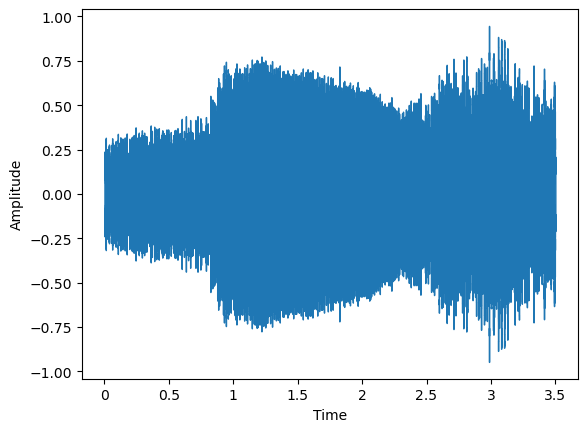

In [4]:
signal,sr = librosa.load(CAPUCHIN,sr=22050) 
librosa.display.waveshow(signal,sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [5]:
#fast fourier transform computation
fft = np.fft.fft(signal)
magnitude = np.abs(fft)
print(fft)
print("---------------")
print(magnitude)
# fft.shape

[-2.71802108+0.j         -2.69407494-0.01210386j -2.63124345-0.03437091j
 ... -2.64251878-0.05057926j -2.63124345+0.03437091j
 -2.69407494+0.01210386j]
---------------
[2.71802108 2.69410213 2.63146793 ... 2.64300279 2.63146793 2.69410213]


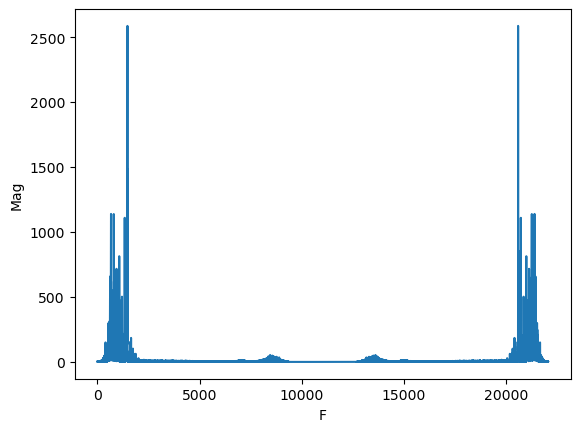

In [6]:
#contribution of each frequency's value to the outputs
freq = np.linspace(0,sr,len(magnitude))
plt.plot(freq,magnitude)
plt.xlabel("F")
plt.ylabel("Mag")
plt.show()

As we can see above, the fast fourier transform mathematically produces a symmetric array of values in 2 halves, so the useful information can be obtained from either half

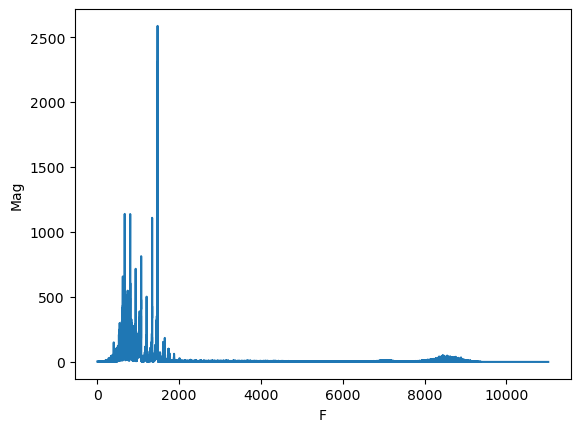

In [7]:
left_frequency = freq[:int(len(freq)/2)]
left_mag = magnitude[:int(len(freq)/2)]
plt.plot(left_frequency,left_mag)
plt.xlabel("F")
plt.ylabel("Mag")
plt.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_23476\710446311.py:3: FutureWarning: Pass n_fft=2048, hop_length=256 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  stft = librosa.core.stft(signal,num_samples_fft,hop_length)


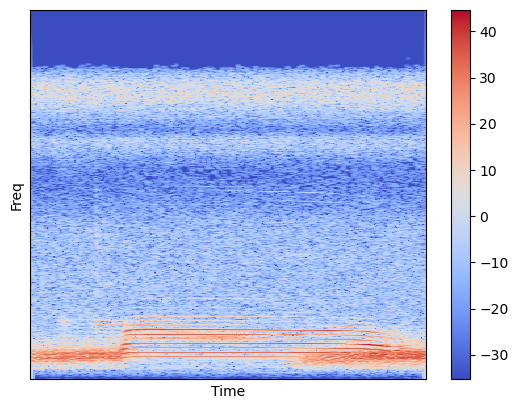

In [8]:
num_samples_fft = 2048 #window size
hop_length = 256 #stride for the window for the spectrogram
stft = librosa.core.stft(signal,num_samples_fft,hop_length)
spectrogram = np.abs(stft)
mel_spectrogram = librosa.amplitude_to_db(spectrogram)
librosa.display.specshow(mel_spectrogram,sr=sr,hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Freq")
plt.colorbar() #to show how the amplitude varies in the spectrogram
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_23476\2617682345.py:1: FutureWarning: Pass y=[ 0.09433126  0.09510415  0.03808597 ... -0.0354804   0.01801272
  0.04313491] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfcc = librosa.feature.mfcc(signal,sr=22050,hop_length=hop_length,n_fft=num_samples_fft,n_mfcc=25)


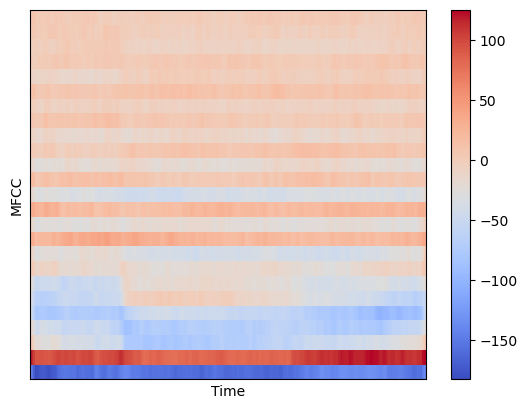

In [9]:
mfcc = librosa.feature.mfcc(signal,sr=22050,hop_length=hop_length,n_fft=num_samples_fft,n_mfcc=25)
librosa.display.specshow(mfcc,sr=sr,hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar() #to show how the amplitude varies in the spectrogram
plt.show()

## PREPROCESS DATASET AND EXTRACT FEATURES

In [10]:
import os
import math
import json

In [13]:
duration = 1 #seconds
sample_per_file = 22050*duration
def save_mfccs(dataset_path,dump_path,n_mfccs=25,n_fft=2048,hop_length=512,num_segments=2):
    data = {
        "mapping":[],
        "mfcc":[],
        "labels":[]
    }

    num_sample_segment=int(sample_per_file/num_segments)
    vectors_per_segment = math.ceil(num_sample_segment/hop_length)
    for i,(dirpath,dirname,filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            dirpath_parts = dirpath.split("/")
            label = dirpath_parts[-1]
            data["mapping"].append(label)
            print("\n Processing {}".format(label))

            #now load files and process to return mfccs
            for f in filenames:
                file_path = os.path.join(dirpath,f)
                signal,sr = librosa.load(file_path,sr=22050)

                for s in range(num_segments):
                    start_sample = num_sample_segment * s
                    finish_sample = start_sample + num_sample_segment
                    mfccs = librosa.feature.mfcc(y=signal[start_sample:finish_sample],sr=22050,n_fft=n_fft,n_mfcc=n_mfccs,hop_length=hop_length)
                    mfccs = mfccs.T
                
                    if(len(mfccs))==vectors_per_segment:
                        data["mfcc"].append(mfccs.tolist())
                        data["labels"].append(i-1)
                        print("{} segment #:{}".format(file_path,s+1))
    with open(dump_path,"w") as fp:
        json.dump(data,fp,indent=4) 

In [ ]:
save_mfccs(dataset_path="data",dump_path="data_forest_rec.json")

In [15]:
from sklearn.model_selection import train_test_split
from keras.api._v2.keras.models import Sequential
from keras.api._v2.keras.optimizers import Adam
from keras.api._v2.keras.layers import Dropout,LSTM,BatchNormalization,Dense,TimeDistributed,Flatten

In [16]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data("data_forest_rec.json")

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation,y_test
def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = Sequential()
    model.add(LSTM(units=128,input_shape=input_shape,return_sequences=True))
    model.add(BatchNormalization())
    model.add(LSTM(units=128,return_sequences=True)) 
    model.add(Dropout(0.2))
    model.add(LSTM(units=128,return_sequences=True)) 
    model.add(LSTM(units=128,return_sequences=True)) 
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64,activation="relu")))
    model.add(TimeDistributed(Dense(32,activation="relu")))
    model.add(TimeDistributed(Dense(16,activation="relu")))
    model.add(TimeDistributed(Dense(8,activation="relu")))
    model.add(Flatten())
    model.add(Dropout(0.2))
    # output layer
    model.add(Dense(4, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[...,np.newaxis] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))

In [17]:
a,b=load_data('data_forest_rec.json')
print(a.shape)
print(b)

(2305, 22, 25)
[0 0 0 ... 3 3 3]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 22, 128)           78848     
                                                                 
 batch_normalization (BatchN  (None, 22, 128)          512       
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 22, 128)           131584    
                                                                 
 dropout (Dropout)           (None, 22, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 22, 128)           131584    
                                                                 
 lstm_3 (LSTM)               (None, 22, 128)           131584    
                                                        

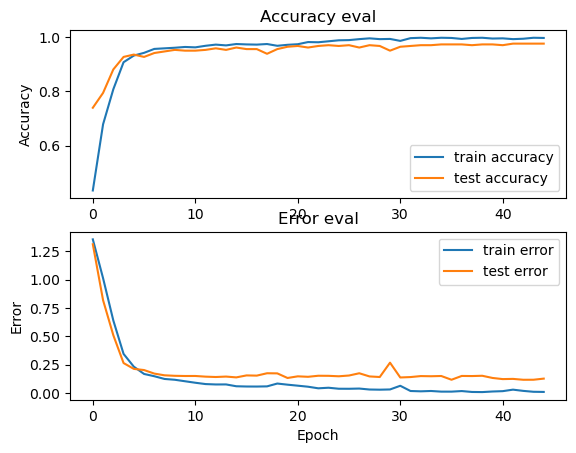

19/19 - 1s - loss: 0.0980 - accuracy: 0.9775 - 698ms/epoch - 37ms/step

Test accuracy: 0.9774696826934814


In [18]:
if __name__ == "__main__":

    # # get train, validation, test splits
    # X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2) #25% testing , 20% of 75 for val

    # # create network
    # input_shape = (X_train.shape[1], X_train.shape[2])
    # model = build_model(input_shape)
    # y_train = np.expand_dims(y_train,axis=-1)
    # y_test = np.expand_dims(y_test,axis=-1)
    # print(X_train.shape)
    # print(y_train.shape)
    # print(X_test.shape)
    # print(y_test.shape)
    # # compile model
    # optimiser = Adam(learning_rate=0.0001)
    # model.compile(optimizer=optimiser,
    #               loss='sparse_categorical_crossentropy',
    #               metrics=['accuracy',tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

    # model.summary()

    # # train model
    # history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # # plot accuracy/error for training and validation
    # plot_history(history)

    # # evaluate model on test set
    # test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    # print('\nTest accuracy:', test_acc)

    # # pick a sample to predict from the test set
    # X_to_predict = X_test[100]
    # y_to_predict = y_test[100]

    # # predict sample
    # predict(model, X_to_predict, y_to_predict)
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
    model = build_model(input_shape)

    # compile model
    optimiser = Adam(learning_rate=0.0001,beta_1=0.5,beta_2=0.999)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=45)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

In [19]:
preds = model.predict(X_test)

19/19 [==============================] - 7s 32ms/step


In [45]:
X_test.shape

(577, 22, 25)

In [22]:
np.set_printoptions(suppress=True)


In [23]:
preds[100]

array([0.00000101, 0.00000018, 0.9999969 , 0.00000193], dtype=float32)

In [24]:
y_test[100]

2

In [25]:
ans = [np.argmax(y) for y in preds]
ans = np.array(ans)
ans=ans.T

In [26]:
print(ans[100])
y_test[100]

2


2

In [27]:
output= ans == y_test
print(output)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True False  True  True
  True  True  True  True  True  True  True False  T

In [28]:
print(X_test.shape)

(577, 22, 25)


In [29]:
X_to_predict = X_test[10]
y_to_predict = y_test[10]
print(X_to_predict.shape)
print(y_to_predict)

(22, 25)
2


In [30]:
 # pick a sample to predict from the test set
X_to_predict = X_test[109]
X_to_predict = X_to_predict[np.newaxis,...]
print(X_to_predict.shape)
y_to_predict = y_test[109]
print(y_to_predict)
# predict sample
preds = model.predict(X_to_predict)
print(preds)
ans = [np.argmax(y) for y in preds]
ans = np.array(ans)
ans=ans.T

print("Predicted label: {}, actual label : {}".format(ans,y_to_predict))

(1, 22, 25)
2
1/1 [==============================] - 0s 123ms/step
[[0.00000603 0.00000238 0.9999796  0.00001195]]
Predicted label: [2], actual label : 2


In [31]:
sample = "W_Forest/gun_bird_test.wav"


In [70]:
duration = 1 #seconds
sample_per_file = 22050*duration
def save_mfccs_test(file_path,dump_path,n_mfccs=25,n_fft=2048,hop_length=512,num_segments=2):
    data = {
        "mapping":[],
        "mfcc":[],
        # "labels":[]
    }

    num_sample_segment=int(sample_per_file/num_segments)
    vectors_per_segment = math.ceil(num_sample_segment/hop_length)
    
    # file_path = os.path.join(dirpath,f)
    signal,sr = librosa.load(file_path,sr=22050)

    for s in range(num_segments):
        start_sample = num_sample_segment * s
        finish_sample = start_sample + num_sample_segment
        mfccs = librosa.feature.mfcc(y=signal[start_sample:finish_sample],sr=22050,n_fft=n_fft,n_mfcc=n_mfccs,hop_length=hop_length)
        mfccs = mfccs.T
    
        if(len(mfccs))==vectors_per_segment:
            data["mfcc"].append(mfccs.tolist())
            print("{} segment #:{}".format(file_path,s+1))

    with open(dump_path,"w") as fp:
        json.dump(data,fp,indent=4) 

In [71]:
def load_data_test(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    return X

In [72]:
# fp = "split_audio_files/clip0.wav"

In [85]:
import os
directory = "split_audio_files"

for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    if os.path.isfile(filepath):
        # print(filepath.split('c')[1][:-4:])
        # print(os.path.join("split_audio_files_outputs",filepath.split('c')[1][:-4:]+".json"))
        save_mfccs_test(file_path=filepath,dump_path=os.path.join("split_audio_files_outputs",filepath.split('c')[1][:-4:]+".json"))
        # break


split_audio_files\clip0.wav segment #:1
split_audio_files\clip0.wav segment #:2
split_audio_files\clip1.wav segment #:1
split_audio_files\clip1.wav segment #:2
split_audio_files\clip10.wav segment #:1
split_audio_files\clip10.wav segment #:2
split_audio_files\clip11.wav segment #:1
split_audio_files\clip11.wav segment #:2
split_audio_files\clip12.wav segment #:1
split_audio_files\clip12.wav segment #:2
split_audio_files\clip13.wav segment #:1
split_audio_files\clip13.wav segment #:2
split_audio_files\clip14.wav segment #:1
split_audio_files\clip14.wav segment #:2
split_audio_files\clip15.wav segment #:1
split_audio_files\clip15.wav segment #:2
split_audio_files\clip16.wav segment #:1
split_audio_files\clip16.wav segment #:2
split_audio_files\clip17.wav segment #:1
split_audio_files\clip17.wav segment #:2
split_audio_files\clip18.wav segment #:1
split_audio_files\clip18.wav segment #:2
split_audio_files\clip19.wav segment #:1
split_audio_files\clip19.wav segment #:2
split_audio_files\cl

In [73]:
# save_mfccs_test(file_path=fp,dump_path="clip0.json")

split_audio_files/clip0.wav segment #:1
split_audio_files/clip0.wav segment #:2


In [114]:
class_list = ["gun","cap","ambient","lion"]


In [134]:
directory = "split_audio_files_outputs"

for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    if os.path.isfile(filepath):
        # print(filepath.split('c')[1][:-4:])
        # print(os.path.join("split_audio_files_outputs",filepath.split('c')[1][:-4:]+".json"))
        print(f"-------{filepath}---------")
        a=load_data_test(filepath)
        preds = model.predict(a)
        names = [(class_list[np.argmax(x)]) for x in preds]
        print(names)
        print("\n\n---------")




-------split_audio_files_outputs\lip0.json---------
1/1 [==============================] - 0s 37ms/step
['ambient', 'ambient']


---------
-------split_audio_files_outputs\lip1.json---------
1/1 [==============================] - 0s 42ms/step
['gun', 'gun']


---------
-------split_audio_files_outputs\lip10.json---------
1/1 [==============================] - 0s 46ms/step
['ambient', 'gun']


---------
-------split_audio_files_outputs\lip11.json---------
1/1 [==============================] - 0s 38ms/step
['ambient', 'ambient']


---------
-------split_audio_files_outputs\lip12.json---------
1/1 [==============================] - 0s 36ms/step
['gun', 'gun']


---------
-------split_audio_files_outputs\lip13.json---------
1/1 [==============================] - 0s 40ms/step
['ambient', 'ambient']


---------
-------split_audio_files_outputs\lip14.json---------
1/1 [==============================] - 0s 39ms/step
['ambient', 'ambient']


---------
-------split_audio_files_outputs\lip15.jso

In [130]:
a=load_data_test('split_audio_files_outputs/lip5.json')
print(a.shape)
# print(b)

(2, 22, 25)


In [131]:
preds = model.predict(a)

1/1 [==============================] - 0s 113ms/step


In [132]:
names = [(class_list[np.argmax(x)]) for x in preds]

In [133]:
names


['ambient', 'ambient']

In [129]:
preds

array([[0.9999927 , 0.0000035 , 0.00000177, 0.00000208],
       [0.03097927, 0.9662479 , 0.00229924, 0.00047347]], dtype=float32)

## TESTING INPUT (FIXING)

In [ ]:
duration = 1 #seconds
sample_per_file = 22050*duration
def save_mfccs_test(file_path,dump_path,n_mfccs=25,n_fft=2048,hop_length=512,num_segments=3):
    data = {
        "mapping":[],
        "mfcc":[],
        # "labels":[]
    }

    num_sample_segment=int(sample_per_file/num_segments)
    vectors_per_segment = math.ceil(num_sample_segment/hop_length)
    
    # file_path = os.path.join(dirpath,f)
    signal,sr = librosa.load(file_path,sr=22050)

    for s in range(num_segments):
        start_sample = num_sample_segment * s
        finish_sample = start_sample + num_sample_segment
        mfccs = librosa.feature.mfcc(y=signal[start_sample:finish_sample],sr=22050,n_fft=n_fft,n_mfcc=n_mfccs,hop_length=hop_length)
        mfccs = mfccs.T
    
        if(len(mfccs))==vectors_per_segment:
            data["mfcc"].append(mfccs.tolist())
            print("{} segment #:{}".format(file_path,s+1))

    with open(dump_path,"w") as fp:
        json.dump(data,fp,indent=4) 

In [104]:
signal,sr = librosa.load("Parsed_Capuchinbird_Clips/XC114131-1.wav",sr=22050)

# start_sample = num_sample_segment * s
# finish_sample = start_sample + num_sample_segment
mfccs = librosa.feature.mfcc(y=signal,sr=22050,n_fft=2048,n_mfcc=25,hop_length=512)
mfccs = mfccs.T
print(len(mfccs))
tt_test = mfccs
tt_test = tt_test[np.newaxis,...]
tt_test.shape

94


(1, 94, 25)

In [105]:
pred = model.predict(tt_test)
pred

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_4/flatten_4/Reshape' defined at (most recent call last):
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Asus\AppData\Local\Temp\ipykernel_23260\1832937689.py", line 1, in <cell line: 1>
      pred = model.predict(tt_test)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Asus\anaconda3\envs\torch-gpu\lib\site-packages\keras\layers\reshaping\flatten.py", line 104, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential_4/flatten_4/Reshape'
Input to reshape is a tensor with 752 values, but the requested shape requires a multiple of 88
	 [[{{node sequential_4/flatten_4/Reshape}}]] [Op:__inference_predict_function_77035]